# Comparison of results from different algrithms and input sets

In this notebook we will compare the metrics output by training and evaluation runs of each of the definition files in [the examples directory](https://github.com/MetOffice/XBTs_classification/tree/master/examples) on GitHub. We will compare the per year recall for each algorthm/input features combo as well as looking at the overall scores to choose a best classification pipeline to recommend for use with the EN4 dataset.

### Environment and library setup
The results are stored in CSV files, so we will use pandas and matplotlib to load and visualise the metrics. 

In [1]:
import pandas
import os
import sys
from pathlib import Path
import functools
import re

In [2]:
import matplotlib
import matplotlib.pyplot

In [3]:
import sklearn.metrics

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [6]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}


In [7]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [8]:
input_dir_name = 'csv_with_imeta'
plot_dir_name = 'plots'
exp_out_dir_name = 'report_outputs_202008'
imeta_dir = 'imeta'

In [9]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name)
xbt_imeta_path   = os.path.join(root_data_dir, imeta_dir)
xbt_plots_dir = os.path.join(root_data_dir, plot_dir_name)

# Finding the results files
The experiment output directory is arranged as one output directory per experiment definition file. Each directory will have:
* `xbt_metrics_<experiment_name>_<datestamp>.json` - the CSV file with per year and per instrument metrics
* `xbt_score_<experiment_name>_<datestamp>.json` - the CSV file with average metrics for all data in train and test sets.
* `xbt_classifications_<experiment_name>.csv`  -  a file containing the input data as well as the classifcation produced with the classifier trained in the experiment.
* `xbt_classifier_<RandomForest_country>_<split_num>.joblib` - one file for each outer split, containing the saved state of the classifier trained on that split.
* `xbt_param_<experiment_name>_inference.json` - The experiment definition file used for this experiment, with the addition of a list of classifier state file. This file should be used to run the inference script with classifiers that have been trained in this experiment.

The code below find all the metrics and score result files and extracts relevant subsets into dataframes for plotting.

In [10]:
metrics_prefix = 'xbt_metrics'
score_prefix = 'xbt_score'

In [11]:
regex_metrics_files = metrics_prefix + '_(?P<classifier>([a-zA-Z]+))_(?P<features>([a-zA-Z]+))(_cv)*_(?P<timestamp>[0-9_]+)'
regex_score_files = score_prefix + '_(?P<classifier>([a-zA-Z]+))_(?P<features>([a-zA-Z]+))(_cv)*_(?P<timestamp>[0-9_]+)'

In [12]:
imeta_metrics = pandas.read_csv(os.path.join(xbt_imeta_path, 'xbt_metrics_imeta.csv'))                             

In [13]:
imeta_metrics

,Unnamed: 0,year,imeta_instr_recall_all,imeta_instr_precision_all,imeta_instr_f1_all
0,0,1966,1.000000,1.000000,1.000000
1,1,1967,0.999893,0.999893,0.999893
2,2,1968,0.990069,0.990069,0.990069
3,3,1969,0.961154,0.961154,0.961154
4,4,1970,0.959794,0.959794,0.959794
5,5,1971,0.966530,0.966530,0.966530
6,6,1972,0.967706,0.967706,0.967706
7,7,1973,0.978304,0.978304,0.978304
8,8,1974,0.978483,0.978483,0.978483
9,9,1975,0.969601,0.969601,0.969601


In [14]:
metric_tuples1 = [ (dir_list[0], sorted([fname1 for fname1 in dir_list[2] if 'xbt_metrics' in fname1])[-1]) for dir_list in os.walk(xbt_output_dir) if len([fname1 for fname1 in dir_list[2] if 'xbt_metrics' in fname1]) > 0]
metric_tuples1 = [(i1[0],i1[1], re.search(regex_metrics_files, i1[1])) for i1 in metric_tuples1]

In [15]:
metrics_files_dict = {'{0}_{1}'.format(t1[2].group('classifier'), t1[2].group('features')): 
 {
    'classifier': t1[2].group('classifier'),
    'features': t1[2].group('features'),
    'timestamp': t1[2].group('timestamp'),
    'dir': t1[0],
    'fname': t1[1],
     'path': os.path.join(t1[0], t1[1]),
 }
    for t1 in metric_tuples1}

In [16]:
metrics_list = {k1: pandas.read_csv(v1['path']) for k1, v1 in metrics_files_dict.items()}

In [17]:
metrics_ens = {k1: v1[[c1 for c1 in v1.columns if 'ens' in c1 and 'recall' in c1] + ['year']] for k1,v1 in metrics_list.items()}


Here we find the recall for each classifier per year for each experiment and each split in that experiment, as well as the average recall across all split, for training and test data.

In [18]:
metrics_train_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'train_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_list.items()}

metrics_test_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'test_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_list.items()}


In [19]:
metrics_cons_train1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_list.items()]) 
metrics_cons_test1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_list.items()]) 

In addition to results for individual classifiers, we are also interested in the recall for the ensemble vote-based probability classifier, which is extract here.

In [20]:
#creating more descriptive names
d1_rename = {
    'RandomForest_country': 'RandomForest_countryMaxDepthYear',
    'RandomForest_countryLatLon': 'RandomForest_countryLatLonMaxDepthYear',
    'decisionTree_country': 'decisionTree_countryMaxDepthYear',
    'decisionTree_countryLatLon': 'decisionTree_countryLatLonMaxDepthYear',
    'decisionTree_latLon': 'decisionTree_latLonMaxDepthYear',
    'decisionTree_maxDepthYear': 'decisionTree_maxDepthYear',
    'decisionTree_country': 'decisionTree_countryMaxDepthYear',
    'knn_country': 'knn_countryMaxDepthYear',
    'RandomForest_country': 'RandomForest_countryMaxDepthYear',
    'logreg_country': 'logreg_countryMaxDepthYear',
    'mlp_country': 'RandomForest_countryMaxDepthYear',
    'mlp_countryLatLon': 'mlp_countryLatLonMaxDepthYear',
}
clf_list = list(d1_rename.values())

In [21]:
d1 = {k1: m1['recall_ens_unseen_all'] for k1,m1 in metrics_list.items()}
d1.update({'year': metrics_list['decisionTree_country']['year']})
metrics_recall_ens_unseen = pandas.DataFrame(d1)
metrics_recall_ens_unseen = metrics_recall_ens_unseen.rename(columns=d1_rename)

## Results from different classifiers

Here we compare the recall metric for the different classifiers used and different input features.

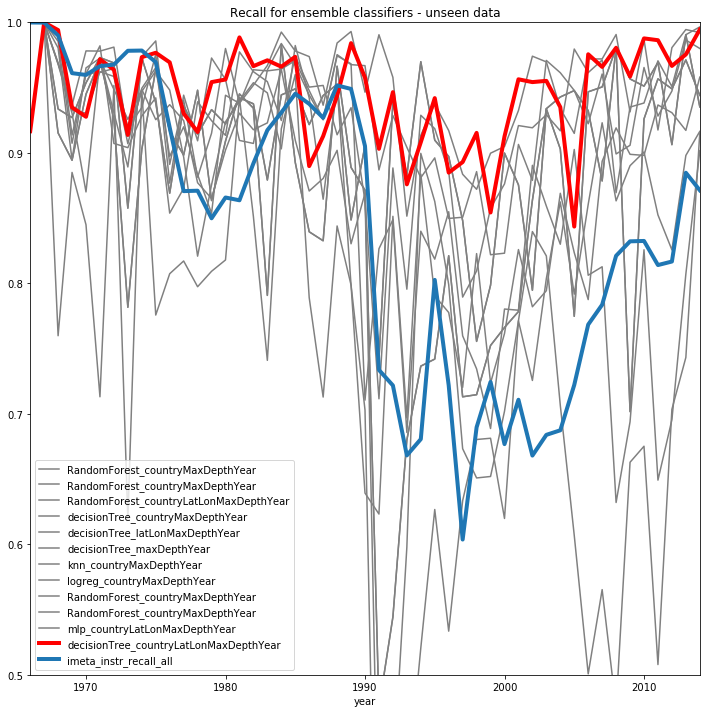

In [37]:
fig_ens_recall = matplotlib.pyplot.figure('results_ens_unseen', figsize=(12,12))
ax_ens_recall = fig_ens_recall.add_subplot(1,1,1, title='Recall for ensemble classifiers - unseen data')

metrics_recall_ens_unseen.plot.line(x='year', 
                                    y= [c1 for c1 in clf_list if 'decisionTree_countryLatLonMaxDepthYear' != c1],
                                    ylim=[0.5, 0.1], 
                                    ax=ax_ens_recall,
                                    c='grey'
                                   )

metrics_recall_ens_unseen.plot.line(x='year', 
                                    y= 'decisionTree_countryLatLonMaxDepthYear',
                                    ylim=[0.5, 0.1], 
                                    ax=ax_ens_recall,
                                    c='r',
                                    linewidth=4,
                                   )

imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_ens_recall, ylim=[0.5, 1.0], linewidth=4)
fig_ens_recall.savefig(os.path.join(xbt_plots_dir, 'recall_ens_unseen_byYear.png'))

This plot is a bit messy, showing the per year recall for the ensemble classifier on the unseen data. Highlighted in red is the best performing classifier, a decistion tree using max depth, country, year and lat/lon as input featues. 

Actually it is about tied overall with Random Forest using the same input features, but is quicker to train and easier to understand, so I am recommending this for use with the EN4 dataset at this stage.

### Update 18/08/2020
An additional thing to note is that these results are not produced using a full automated hyperparameter tuning script which has been developer, as we get some quite poor accuracy results compared to what has been done here, which is to select the parameters that produced the best results in those scripts and used it with a standard cross-validation run using those hyper parameters to produce the results shown here. This is what the XBT scripts will do for producing classification for the EN4 dataset will for now. There is probably a bug somewhere in how I am using the hyperparameter tuning which needs investigating.

here we break apart the results shown in the previous plot firstly showing recall for train and test sets for all algorithms together (the mean recall per year across all the splits), followed by the recall per year for train and test sets for each experiment separately, as well as the ensemble result, comapred with iMeta. 

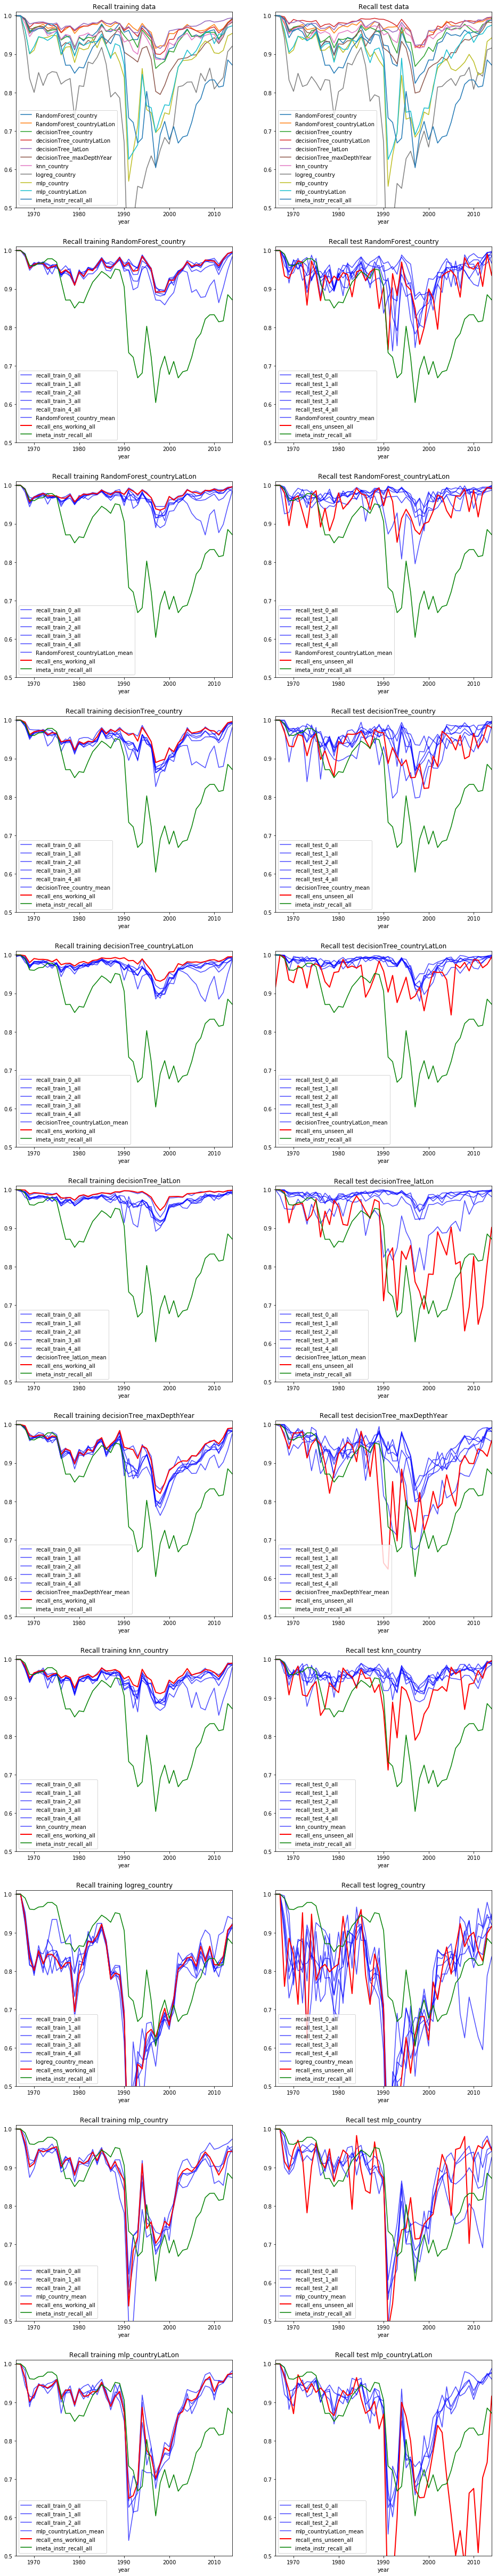

In [23]:
num_rows = len(metrics_cons_train1.keys())
ylim = [0.5,1.01]

fig_results = matplotlib.pyplot.figure('results1', figsize=(16, 8*(num_rows+1)))
ax_train = fig_results.add_subplot(num_rows+1, 2, 1, title='Recall training data')
metrics_cons_train1.plot.line(x='year', ax=ax_train, ylim=ylim)
ax_test = fig_results.add_subplot(num_rows+1, 2, 2, title='Recall test data')
metrics_cons_test1.plot.line(x='year', ax=ax_test, ylim=ylim)

imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim)
imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim)

ix1 = 1
for k1, v1 in metrics_train_perClassifier.items():
    ax_train = fig_results.add_subplot(num_rows+1, 2 , ix1*2 + 1, title='Recall training {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_train, ylim=[0.5,1.1],c='b',alpha=0.7)
    metrics_ens[k1].plot.line(x='year', y='recall_ens_working_all', ax=ax_train,c='r',linewidth=2.0)
    imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim, c='g')
    ix1 += 1
ix1 = 1    
for k1, v1 in metrics_test_perClassifier.items():
    ax_test = fig_results.add_subplot(num_rows+1, 2, ix1*2 + 2, title='Recall test {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_test, ylim=[0.5,1.1],c='b',alpha=0.7)
    metrics_ens[k1].plot.line(x='year', y='recall_ens_unseen_all', ax=ax_test,c='r',linewidth=2.0)
    imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim,c='g')
    ix1 += 1
    


What graphs and tables do we want to show here to justify our decision of which classifier type and what set of input features we are recommending to use?

* averages for each classifier
* show all member, average and max prob metrics for each classifier
* compare to imeta baseline for each
* come up with one number for each classifier to choose the best classifier.

Other questions:
* Do we want to compare per class performance
* more analysis of per cruise performance

## And now, the winner is...

In order to select a classifier to use, we need to choose a metric to rank them on. We have chosen the recall for the ensemble classifier on the unseen data as best representing which classifier will perform best on the unlabelled data.

In [24]:
score_tuples1 = [ (dir_list[0], sorted([fname1 for fname1 in dir_list[2] if score_prefix in fname1])[-1]) for dir_list in os.walk(xbt_output_dir) if len([fname1 for fname1 in dir_list[2] if score_prefix in fname1]) > 0]
score_tuples1 = [(i1[0],i1[1], re.search(regex_score_files, i1[1])) for i1 in score_tuples1]

In [25]:
scores_files_dict = {'{0}_{1}'.format(t1[2].group('classifier'), t1[2].group('features')): 
 {
    'classifier': t1[2].group('classifier'),
    'features': t1[2].group('features'),
    'timestamp': t1[2].group('timestamp'),
    'dir': t1[0],
    'fname': t1[1],
     'path': os.path.join(t1[0], t1[1]),
 }
    for t1 in score_tuples1}

In [26]:
scores_list = {k1: pandas.read_csv(v1['path']) for k1, v1 in scores_files_dict.items()}

In [27]:
current_metric = 'recall_all'

In [28]:
current_subset = 'train'
functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_list.items()])

,name,RandomForest_country,logreg_country,decisionTree_countryLatLon,decisionTree_latLon,decisionTree_maxDepthYear,RandomForest_countryLatLon,knn_country,mlp_country,mlp_countryLatLon,decisionTree_country
0,ens_working,0.950408,0.780011,0.976362,0.984880,0.927779,0.972925,0.955186,0.871588,0.884771,0.952828
1,train_0,0.925490,0.783862,0.948463,0.966668,0.899629,0.946119,0.926133,0.882774,0.888963,0.926226
2,train_1,0.952496,0.781656,0.964880,0.965670,0.911979,0.974710,0.945148,0.852722,0.886678,0.952426
3,train_2,0.951168,0.786772,0.961372,0.966342,0.929436,0.964906,0.943750,0.870298,0.871184,0.942320


In [29]:
current_subset = 'test'
functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_list.items()])

,name,RandomForest_country,logreg_country,decisionTree_countryLatLon,decisionTree_latLon,decisionTree_maxDepthYear,RandomForest_countryLatLon,knn_country,mlp_country,mlp_countryLatLon,decisionTree_country
0,test_0,0.951186,0.794912,0.980642,0.982497,0.933174,0.974075,0.958768,0.828361,0.880931,0.963338
1,test_1,0.918463,0.791681,0.966570,0.983980,0.931034,0.943176,0.958496,0.866101,0.879966,0.909650
2,test_2,0.916309,0.745215,0.975349,0.984741,0.860579,0.971710,0.962133,0.883526,0.878974,0.953814


In [30]:
current_subset = 'unseen'
recall_unseen_df = functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_list.items()])
recall_unseen_df

,name,RandomForest_country,logreg_country,decisionTree_countryLatLon,decisionTree_latLon,decisionTree_maxDepthYear,RandomForest_countryLatLon,knn_country,mlp_country,mlp_countryLatLon,decisionTree_country
0,ens_unseen,0.910673,0.781702,0.943744,0.837927,0.865445,0.943030,0.918142,0.858085,0.763651,0.918746
1,unseen_0,0.904981,0.796099,0.937225,0.828522,0.858798,0.939757,0.911901,0.860406,0.753957,0.914864
2,unseen_1,0.908619,0.780201,0.937216,0.821386,0.859834,0.942047,0.908187,0.844916,0.766248,0.910407
3,unseen_2,0.909761,0.778599,0.934576,0.821946,0.860018,0.941918,0.913541,0.863375,0.754288,0.914989


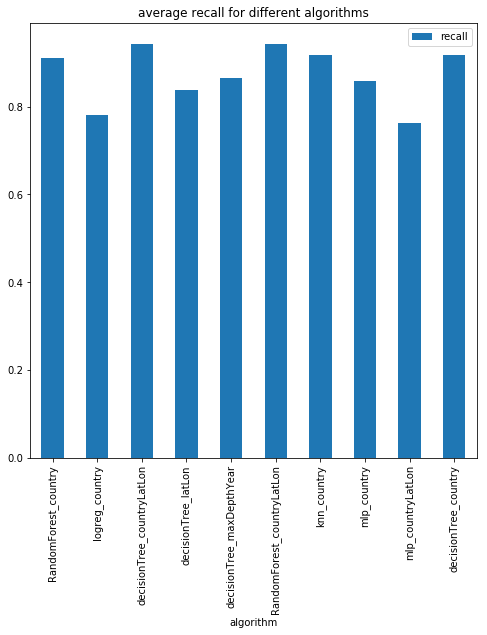

In [39]:
fig_avg_recall = matplotlib.pyplot.figure('avg_recall', figsize=(8,8))
ax_avg_recall = fig_avg_recall.add_subplot(1,1,1, title='average recall for different algorithms')
pandas.DataFrame.from_records([{'algorithm': k1, 'recall': float(s1[s1.name == 'ens_unseen']['recall_all'])} for k1, s1 in scores_list.items()]).plot.bar(x='algorithm', ax=ax_avg_recall)
fig_avg_recall.savefig(os.path.join(xbt_plots_dir, 'xbt_avg_recall_unseen.png'),bbox_inches='tight')

The top performer is close between random forest and decision tree. This is surprising that the flexibility of random forest is not giving much of an advantage. As a result based on the results we have produced at this stage (August 2020), **we recommend a decision tree** using the same input features as the intelligent metadata, specifically 
* country
* maximum depth
* year
* location given by latitude/longtitude.

## Further work (18 August 2020)

There seem to be some bug in the pipeline so far when using certain options which degrade accuracy. it would be best to able to use these options in the training script to ensure robustness of the results. These issues include:

* when taking the year into account when doing the outer split into unseen/(train/test) sets, the results are much worse, particularly for later years. This is not expected if the split is being done correctly, so it suggests something is wrong, but stats of the splits look right, so there may a more subtle error.
* using the grid search hyperparameter tuning with the outer cross validation, results are substantinally worse than separately find the best parameter and then running cross validation with those hyperparameters. With nested CV and HPT, inner training is done on less daa, which may be a contributing factor, but after HPT is done, all the data for each split is used for training, so I would expect equivalent recall values for not using ested HPT.
